In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Question 1 ###

In [2]:
#import OIS discount factor data
df_OIS = pd.read_excel('IR Data.xlsx', sheet_name='OIS').iloc[:,0:3]
df_IRS = pd.read_excel('IR Data.xlsx', sheet_name='IRS').iloc[:,0:3]

In [3]:
#change the Tenor Column to numbers
def calibrate_tenor(column):
    for i in range(len(column)):
        if column[i].endswith('m'):
            column[i] = float(column[i][:-1])/12
        elif column[i].endswith('y'):
            column[i] = float(column[i][:-1])

calibrate_tenor(df_OIS['Tenor'])
calibrate_tenor(df_IRS['Tenor'])

In [4]:
df_OIS= df_OIS.rename (columns = {"Rate":"OIS_Rate"})
df_IRS= df_IRS.rename (columns = {"Rate":"IRS_Rate"})

In [5]:
#Add discount column
df_OIS['OIS_DF'] = np.nan
df_OIS['f'] = np.nan

$$ OIS_{1y} =(1+\frac{f_0}{360})^{360}-1$$

$$ D_o(0,1y) = \frac{1}{(1+\frac{f_0}{360})^{(T*360)}} $$

In [6]:
df_OIS['f'][0] = 360*((1+0.5*0.0025)**(1/180)-1)
df_OIS['f'][1] = 360*((1+0.003)**(1/360)-1)
df_OIS['OIS_DF'][0] = 1/(1+0.5*0.0025)
df_OIS['OIS_DF'][1] = 1/(1+0.003)

In [7]:
Time = np.arange(1,30.5,1)
Tenor_df = pd.DataFrame(data=Time, columns=['Tenor'])
data = []
data.insert(0,{'Tenor':0.5})
Tenor_df = pd.concat([pd.DataFrame(data), Tenor_df], ignore_index=True)
df_OIS = pd.merge(Tenor_df,df_OIS,on="Tenor", how="left").drop('Product' , axis =1 )

In [8]:
# define a root search function(bisect)
def bisect_func(f, a, b, tol):
    assert(a < b and f(a) * f(b) < 0)
    c = (a+b) / 2
    while (b-a)/2 > tol:
        c = (a+b)/2
        if abs(f(c)) < tol:
            return c
        else:
            if f(a) * f(c) < 0:
                b = c
            else:
                a = c
    return c

$$D_o(0,T_n) = D_o(0,T_{n-1})*\frac{1}{(1+\frac{f_n}{360})^{360}}$$
$$fix leg = IRS(0,T_i)*\sum_{n=0.5}^{i} D_o(0,T_n)$$
$$float leg = \sum_{n=0.5}^{i} {D_o(0,T_n) * ((1+\frac{f_n}{360})^{360}-1)}$$
$$float leg = fix leg$$

Linear interpolation:$$ D_O(0,T_n) =D_O(0,T_{n+i}) + \frac{i}{i+j}*(D_O(0,T_{n-j}) - D_O(0,T_{n+i}))$$

In [9]:
#define the function to get equation: float leg - fix leg = 0
#we set last tenor OIS_Discount(0,Ti) as x ,and use bisect_func to solve the equation
def get_OIS_func(x): 
    float_unknown_sum = df_OIS['OIS_DF'][i-1] - x # after reduction, the unknown float sum becomes D[i-1] - D_last
    fix_discount_unknown_sum = 0
    diff = df_OIS['OIS_DF'][i-1] - x
    for n in range(0,h-i+1):
        D = x + ((h-i+1-n-1)/(h-i+1))*diff # linear interpolation on LIBOR discount factor
        fix_discount_unknown_sum += D
    fix_unknown_sum = fix_discount_unknown_sum * df_OIS['OIS_Rate'][h]
    return fix_unknown_sum + fix_known_sum - float_unknown_sum - float_known_sum 

In [10]:
i = 2
while i <=30:
    h = i
    while np.isnan(df_OIS['OIS_Rate'][h]):
        h += 1
    k =1
    fix_known_sum = 0
    while k < i:
        fix_known = df_OIS['OIS_DF'][k]*df_OIS['OIS_Rate'][h]
        fix_known_sum += fix_known
        k+=1
    float_known_sum = df_OIS['OIS_Rate'][i-1]*df_OIS['OIS_DF'][1:i].sum()
    f = lambda x:(get_OIS_func(x)) # float leg - fix leg = 0
    D_last = bisect_func(f, 0, 1, 1e-6) # use bisect_func to solve the equation
    for n in range(0,h-i+1):
        df_OIS['OIS_DF'][i+n] = D_last + ((h-i+1-n-1)/(h-i+1))*(df_OIS['OIS_DF'][i-1] - D_last)
        df_OIS['f'][i+n] = 360*((df_OIS['OIS_DF'][i+n-1]/df_OIS['OIS_DF'][i+n])**(1/360)-1)
    i = h+1

In [11]:
#create a Tenor dataframe
Time = np.arange(0.5,30.5,0.5)
Tenor_df = pd.DataFrame(data=Time, columns=['Tenor'])

#combine Tenor Column and OIS, IRS discount factor df
df_combined = pd.merge(Tenor_df,df_OIS,on="Tenor", how="left")
df_combined = pd.merge(df_combined,df_IRS,on="Tenor", how="left").drop('Product' , axis =1 )

In [12]:
# perform linear interpolation on OIS discount factor
df_combined['OIS_DF'].interpolate(method='linear',inplace=True)

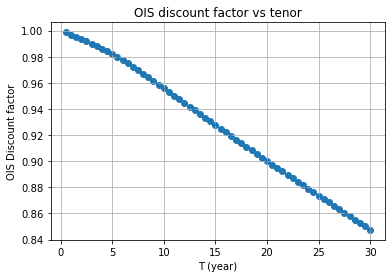

In [13]:
#plot the result
#plt.figure(figsize = (10,10))
plt.plot(df_combined['Tenor'],df_combined['OIS_DF'])
plt.scatter(df_combined['Tenor'],df_combined['OIS_DF'])
plt.xlabel('T (year)')
plt.ylabel('OIS Discount factor')
plt.title('OIS discount factor vs tenor')
plt.grid()
plt.show()

### Question 2 ###

In [14]:
#increase 'Foward_LIBOR' and 'LIBOR_DF' column
df_combined['Foward_LIBOR'] = np.nan
df_combined['LIBOR_DF'] = np.nan

$$ D(0,0.5) = \frac{1}{1+0.5*L(0,0.5)}$$

In [15]:
# L(0,0.5) = IRS(0,0.5) 
# calculate LIBOR_Discount(0,0.5)
df_combined['Foward_LIBOR'][0]=df_combined['IRS_Rate'][0]
df_combined['LIBOR_DF'][0]= 1/(1+0.5*df_combined['Foward_LIBOR'][0])

$$fix leg = 0.5*IRS\ rate*\sum_{i=0.5}^{n} D_o(0,T_i)$$
$$float leg = 0.5*\sum_{i=0.5}^{n} {D_o(0,T_i)*L(T_{i-0.5},T_i)}(Unknown)$$
$$float leg = fix leg$$

Linear interpolation:$$ D_L(0,T_n) =D_L(0,T_{n+i}) + \frac{i}{i+j}*(D_L(0,T_{n-j}) - D_L(0,T_{n+i}))$$

In [16]:
# calculate L(0.5,1) and LIBOR_Discount(0,1)
df_combined['Foward_LIBOR'][1] = (df_combined["IRS_Rate"][1] * (df_combined["OIS_DF"][0]+df_combined["OIS_DF"][1]) - (df_combined['Foward_LIBOR'][0] * df_combined["OIS_DF"][0]))/df_combined["OIS_DF"][1]
df_combined['LIBOR_DF'][1] = (1 / (1 + 0.5 * df_combined['Foward_LIBOR'][0])*(1 / (1 + 0.5* df_combined['Foward_LIBOR'][1])))

In [17]:
df_combined

,Tenor,OIS_Rate,OIS_DF,f,IRS_Rate,Foward_LIBOR,LIBOR_DF
0,0.5,0.00250,0.998752,0.002498,0.0250,0.025000,0.987654
1,1,0.00300,0.997009,0.002996,0.0280,0.031005,0.972577
2,1.5,NaN,0.995270,NaN,NaN,NaN,NaN
3,2,0.00325,0.993530,0.003495,0.0300,NaN,NaN
4,2.5,NaN,0.991773,NaN,NaN,NaN,NaN
5,3,0.00335,0.990015,0.003544,0.0315,NaN,NaN
6,3.5,NaN,0.988066,NaN,NaN,NaN,NaN
7,4,0.00350,0.986116,0.003946,0.0325,NaN,NaN
8,4.5,NaN,0.984150,NaN,NaN,NaN,NaN
9,5,0.00360,0.982183,0.003996,0.0330,NaN,NaN


In [18]:
#define the function to get equation: float leg - fix leg = 0
#we set last tenor LIBOR_Discount(0,Ti) as x ,and use bisect_func to solve the equation
def get_swap_func(x):
    diff = df_combined['LIBOR_DF'][i-2] - x
    D_list = [df_combined['LIBOR_DF'][i-2]]
    L_payoff_list = []
    for n in range(0,h-i+2):
        D = x + ((h-i+2-n-1)/(h-i+2))*diff # linear interpolation on LIBOR discount factor
        L_payoff = 0.5*(2*(D_list[-1]-D)/D)*df_combined['OIS_DF'][i-1+n] # unknown float payoff of each tenor
        D_list.append(D)
        L_payoff_list.append(L_payoff)
    float_unknown_sum = sum(L_payoff_list)
    return float_unknown_sum + float_known_sum - fix_sum

In [19]:
# while loop to solve forward LIBOR rate and LIBOR discount factor of each tenor
i = 3
while i <= 60:
    h = i
    while np.isnan(df_combined['IRS_Rate'][h]): # judge whether we have IRS rate at this tenor
        h += 2 # if not, we jump into next year until we find the year with IRS rate
    fix_sum = 0.5*df_combined['IRS_Rate'][h]*df_combined['OIS_DF'][0:h+1].sum() # fix leg sum
    float_known_sum = 0 # initialize
    k = 0 # initialize
    while k <= i-2:
        float_known = 0.5*df_combined['OIS_DF'][k]*df_combined['Foward_LIBOR'][k] # float leg payoff(known)
        float_known_sum += float_known
        k += 1
    f = lambda x:(get_swap_func(x)) # float leg - fix leg = 0
    D_last =  bisect_func(f, 0, 1, 1e-6)   # use bisect_func to solve the equation
    for n in range(0,h-i+2): # fill in the value
        df_combined['LIBOR_DF'][i-1+n] = D_last + ((h-i+2-n-1)/(h-i+2))*(df_combined['LIBOR_DF'][i-2] - D_last)
        df_combined['Foward_LIBOR'][i-1+n] = (df_combined['LIBOR_DF'][i-2+n]-df_combined['LIBOR_DF'][i-1+n])/\
        (0.5*df_combined['LIBOR_DF'][i-1+n])
    i = h+2 #jump into next year

In [20]:
df_combined

,Tenor,OIS_Rate,OIS_DF,f,IRS_Rate,Foward_LIBOR,LIBOR_DF
0,0.5,0.00250,0.998752,0.002498,0.0250,0.025000,0.987654
1,1,0.00300,0.997009,0.002996,0.0280,0.031005,0.972577
2,1.5,NaN,0.995270,NaN,NaN,0.031751,0.957378
3,2,0.00325,0.993530,0.003495,0.0300,0.032264,0.942179
4,2.5,NaN,0.991773,NaN,NaN,0.034217,0.926331
5,3,0.00335,0.990015,0.003544,0.0315,0.034813,0.910482
6,3.5,NaN,0.988066,NaN,NaN,0.035208,0.894732
7,4,0.00350,0.986116,0.003946,0.0325,0.035839,0.878981
8,4.5,NaN,0.984150,NaN,NaN,0.034713,0.863985
9,5,0.00360,0.982183,0.003996,0.0330,0.035326,0.848989


Text(0, 0.5, 'LIBOR Discount factor')

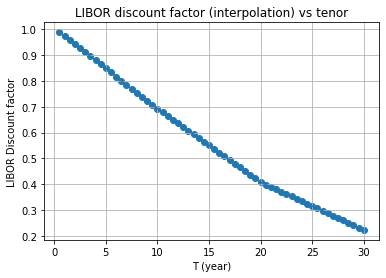

In [21]:
#plot the result
#plt.figure(figsize = (10,10))
plt.plot(df_combined['Tenor'],df_combined['LIBOR_DF'])
plt.scatter(df_combined['Tenor'],df_combined['LIBOR_DF'])
plt.title('LIBOR discount factor (interpolation) vs tenor')
plt.grid()
plt.xlabel('T (year)')
plt.ylabel('LIBOR Discount factor')

### Question 3 ###

In [22]:
df_combined

,Tenor,OIS_Rate,OIS_DF,f,IRS_Rate,Foward_LIBOR,LIBOR_DF
0,0.5,0.00250,0.998752,0.002498,0.0250,0.025000,0.987654
1,1,0.00300,0.997009,0.002996,0.0280,0.031005,0.972577
2,1.5,NaN,0.995270,NaN,NaN,0.031751,0.957378
3,2,0.00325,0.993530,0.003495,0.0300,0.032264,0.942179
4,2.5,NaN,0.991773,NaN,NaN,0.034217,0.926331
5,3,0.00335,0.990015,0.003544,0.0315,0.034813,0.910482
6,3.5,NaN,0.988066,NaN,NaN,0.035208,0.894732
7,4,0.00350,0.986116,0.003946,0.0325,0.035839,0.878981
8,4.5,NaN,0.984150,NaN,NaN,0.034713,0.863985
9,5,0.00360,0.982183,0.003996,0.0330,0.035326,0.848989


$$fix leg = 0.5*S(T_i,T_{i+m})*\sum_{n=i+1}^{i+m} D_o(0,T_n)$$
$$float leg = 0.5*\sum_{n=i+1}^{i+m} {D_o(0,T_n)*L(T_{n-0.5},T_n)}$$
$$float leg = fix leg$$

$$ S(T_i,T_{i+m}) = \frac{0.5*\sum_{n=i+1}^{i+m} {D_o(0,T_n)*L(T_{n-0.5},T_n)}}{0.5*\sum_{n=i+1}^{i+m} D_o(0,T_n)}$$

In [23]:
def par_swap_rate_solver(start,duration):
    end = start + duration
    start_i = start*2 #find the start index
    end_i = end*2-1 #find the end index
    float_leg_sum = 0 # initialize
    fix_discount_sum = 0 # initialize
    while start_i <= end_i:
        float_leg = df_combined['Foward_LIBOR'][start_i]*0.5*df_combined['OIS_DF'][start_i] # float leg value at each tenor
        float_leg_sum += float_leg  
        fix_discount = 0.5*df_combined['OIS_DF'][start_i] #fix discount at each tenor * 0.5
        fix_discount_sum += fix_discount
        start_i += 1
    par_swap_rate = float_leg_sum/fix_discount_sum # formula in the markdown
    return par_swap_rate

In [24]:
df_FowardSwap = pd.DataFrame([['1Y','1Y',par_swap_rate_solver(1,1)],['1Y','2Y',par_swap_rate_solver(1,2)],['1Y','3Y',par_swap_rate_solver(1,3)],['1Y','5Y',par_swap_rate_solver(1,5)],['1Y','10Y',par_swap_rate_solver(1,10)],\
                             ['5Y','1Y',par_swap_rate_solver(5,1)],['5Y','2Y',par_swap_rate_solver(5,2)],['5Y','3Y',par_swap_rate_solver(5,3)],['5Y','5Y',par_swap_rate_solver(5,5)],['5Y','10Y',par_swap_rate_solver(5,10)],\
                            ['10Y','1Y',par_swap_rate_solver(10,1)],['10Y','2Y',par_swap_rate_solver(10,2)],['10Y','3Y',par_swap_rate_solver(10,3)],['10Y','5Y',par_swap_rate_solver(10,5)],['10Y','10Y',par_swap_rate_solver(10,10)]],\
                            columns=['Expiry','Tenor','Swap_Rate'])

In [25]:
df_FowardSwap

,Expiry,Tenor,Swap_Rate
0,1Y,1Y,0.032007
1,1Y,2Y,0.033259
2,1Y,3Y,0.034011
3,1Y,5Y,0.035255
4,1Y,10Y,0.038428
5,5Y,1Y,0.039274
6,5Y,2Y,0.040075
7,5Y,3Y,0.040072
8,5Y,5Y,0.041093
9,5Y,10Y,0.043634


In [26]:
df_combined.to_csv('df_comb.csv',sep=',')

In [27]:
df_FowardSwap.to_csv('df_ForwardSwap.csv',sep=',')